# План работы


1.   Предобработка данных
    
    1.1 Загрузка данных

    1.2 Первичный осмотр данных 

    1.3 Создание единого датафрейма из contract, internet, phones, personal

    1.4 Выделение целевого признака. Разбиение на train и test

        Целевой признак скрыт в столбце "EndDate". Создаем новый столбец target и проставляем 0, если в столбце "EndDate" стоит "No" и  1 если есть конкретная дата. Сам столбец "EndDate" при этом удалим, заменив его на столбец "client_lifetime_month", определяемый как разность в месяцах между "EndDate" и  "BeginDate"

2.   Анализ данных

    2.1 Визуализация данных и поиск взаимосвязей

    2.2 Экспериментирование с комбинациями признаков

    2.3 Выбор признаков для обучения модели

3. Подготовка данных для алгортимов машинного обучения

4. Выбор, обучение и точная настройка моделей
  
  Рассмотрим несколько моделей и подберем для них оптимальные гипер параметры

5. Проверка моделей на тестовой выборке

# Предобработка данных

## Импорты

In [1]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold

## Загрузка данных

In [3]:
#data_contract = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ЯндексПрактикум/финальный проект/dataset/contract.csv')
#data_internet = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ЯндексПрактикум/финальный проект/dataset/internet.csv')
#data_personal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ЯндексПрактикум/финальный проект/dataset/personal.csv')
#data_phone = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ЯндексПрактикум/финальный проект/dataset/phone.csv')

In [4]:
data_contract = pd.read_csv('/datasets/final_provider/contract.csv')
data_internet = pd.read_csv('/datasets/final_provider/internet.csv')
data_personal = pd.read_csv('/datasets/final_provider/personal.csv')
data_phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Первичный осмотр данных

### Контракты

In [5]:
data_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [6]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
data_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [8]:
data_contract['customerID'].unique().size

7043

In [9]:
data_contract['TotalCharges'] = pd.to_numeric(data_contract['TotalCharges'],errors = 'coerce')

In [10]:
data_contract[data_contract.isnull().any(axis=1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [11]:
data_contract = data_contract.dropna(axis=0, how='any')

In [12]:
data_contract[data_contract['BeginDate']=='2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


### Интернет

In [13]:
data_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [14]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [15]:
data_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2232-DMLXU,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


### Телефонная связь

In [16]:
data_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [17]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [18]:
data_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1342-JPNKI,No
freq,1,3390


### Персональные данные

In [19]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [20]:
data_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [21]:
data_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [22]:
data_personal['customerID'].unique().size

7043

## Создание единого датафрейма

In [23]:
data_all = data_contract.merge(data_internet,how='left', on='customerID').merge(data_phone, how='left', on='customerID').merge(data_personal, how='left', on='customerID')

In [24]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   5512 non-null   object 
 9   OnlineSecurity    5512 non-null   object 
 10  OnlineBackup      5512 non-null   object 
 11  DeviceProtection  5512 non-null   object 
 12  TechSupport       5512 non-null   object 
 13  StreamingTV       5512 non-null   object 
 14  StreamingMovies   5512 non-null   object 
 15  MultipleLines     6352 non-null   object 
 16  gender            7032 non-null   object 


In [25]:
data_all

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes
7028,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Female,0,Yes,Yes
7029,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,NaN,Female,0,Yes,Yes
7030,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Yes,Male,1,Yes,No


In [26]:
data_all['Partner'].value_counts()

No     3639
Yes    3393
Name: Partner, dtype: int64

In [27]:
data_all['Dependents'].value_counts()

No     4933
Yes    2099
Name: Dependents, dtype: int64

In [28]:
data_all['Partner'] = data_all['Partner'].replace(['Yes', 'No'], [1, 0])
data_all['Dependents'] = data_all['Dependents'].replace(['Yes', 'No'], [1, 0])

In [29]:
internet_features = data_internet.drop(['customerID'], axis=1).columns
phone_features = data_phone.drop(['customerID'], axis=1).columns

In [30]:
data_all[internet_features] =  data_all[internet_features].fillna('no_internet')
data_all[phone_features] =  data_all[phone_features].fillna('no_phone')

In [31]:
data_all['OnlineBackup'].value_counts()

No             3087
Yes            2425
no_internet    1520
Name: OnlineBackup, dtype: int64

In [32]:
data_all

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,no_phone,Female,0,1,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,Male,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,Male,0,0,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,no_phone,Male,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,Female,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Male,0,1,1
7028,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Female,0,1,1
7029,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,no_phone,Female,0,1,1
7030,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Yes,Male,1,1,0


## Выделение целевого признака. Разбиение на train и test

In [33]:
def target(x):
  if x == 'No':
    return 0
  else:
    return 1

In [34]:
data_all['Target'] = data_all['EndDate'].apply(target)

In [35]:
data_all['Target'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Target, dtype: float64

In [36]:
data_all['BeginDate'] = pd.to_datetime(data_all['BeginDate'], format='%Y-%m-%d')

data_all['EndDate'] = data_all['EndDate'].replace('No', '2020-02-01 00:00:00')
data_all['EndDate'] = pd.to_datetime(data_all['EndDate'], format='%Y-%m-%d %H:%M:%S')

data_all['ClientLifetime_D'] = round((data_all['EndDate'] - data_all['BeginDate'])/np.timedelta64(1,'D'),1)
data_all['ClientLifetime_M'] = round((data_all['EndDate'] - data_all['BeginDate'])/np.timedelta64(1,'M'),1)

In [37]:
data_all['BeginDate'].dt.day.value_counts()

1    7032
Name: BeginDate, dtype: int64

In [38]:
data_all['EndDate'].dt.day.value_counts()

1    7032
Name: EndDate, dtype: int64

In [39]:
data_all['ClientLifetime_M'].value_counts()

1.0     613
72.0    362
2.0     238
3.0     200
4.0     176
       ... 
56.0      5
69.9      4
33.9      4
31.9      4
67.9      2
Name: ClientLifetime_M, Length: 95, dtype: int64

In [40]:
X = data_all.drop(['customerID','EndDate','BeginDate', 'Target'], axis = 1)
y = data_all['Target']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
X_train

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,ClientLifetime_D,ClientLifetime_M
1408,Two year,No,Credit card (automatic),94.55,6078.75,Fiber optic,Yes,Yes,Yes,Yes,No,No,Yes,Male,0,1,1,1979.0,65.0
6992,Month-to-month,No,Electronic check,35.75,1022.50,DSL,No,No,Yes,Yes,No,No,no_phone,Male,0,0,0,792.0,26.0
3349,Two year,No,Credit card (automatic),90.20,6297.65,Fiber optic,No,Yes,Yes,Yes,No,No,Yes,Female,0,1,0,2071.0,68.0
4486,Month-to-month,No,Electronic check,84.30,235.05,Fiber optic,No,Yes,No,No,No,Yes,No,Male,0,0,0,92.0,3.0
3535,Month-to-month,No,Bank transfer (automatic),40.65,2070.75,DSL,Yes,No,No,No,Yes,No,no_phone,Female,0,1,0,1492.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3445,One year,Yes,Bank transfer (automatic),70.95,4555.20,Fiber optic,No,No,No,No,No,No,No,Male,1,1,0,1979.0,65.0
5115,Month-to-month,Yes,Credit card (automatic),75.30,1147.45,Fiber optic,No,Yes,No,No,No,No,No,Female,1,0,0,456.0,15.0
4128,Two year,Yes,Credit card (automatic),92.90,3379.25,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Female,0,1,1,1095.0,36.0
4242,One year,Yes,Mailed check,65.90,660.05,DSL,No,Yes,Yes,No,No,Yes,No,Female,0,1,1,306.0,10.1


# Анализ данных

## Визуализация данных и поиск взаимосвязей

### Количественные признаки

In [43]:
telecom = X_train.join(y_train)

In [44]:
t = telecom.corr()

In [45]:
telecom.corr()['Target'].sort_values(ascending=False)

Target              1.000000
MonthlyCharges      0.193455
SeniorCitizen       0.150970
Partner            -0.154306
Dependents         -0.171178
TotalCharges       -0.197988
ClientLifetime_M   -0.352041
ClientLifetime_D   -0.352152
Name: Target, dtype: float64

<AxesSubplot:>

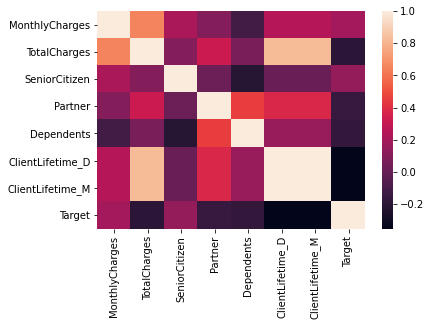

In [46]:
sns.heatmap(t)

In [47]:
telecom['ClientLifetime_M_q'] = pd.qcut(telecom['ClientLifetime_M'],10)
telecom.groupby('ClientLifetime_M_q')['Target'].agg(['count','mean'])

,count,mean
ClientLifetime_M_q,,
"(0.999, 2.0]",673,0.588410
"(2.0, 6.0]",475,0.461053
"(6.0, 12.0]",576,0.369792
"(12.0, 20.0]",555,0.304505
"(20.0, 29.0]",560,0.228571
"(29.0, 40.0]",582,0.202749
"(40.0, 51.0]",560,0.185714
"(51.0, 61.0]",566,0.132509
"(61.0, 69.1]",540,0.092593


Отмечаем, что с ростом ClientLifetime среднее значение Target монотонно уменьшается. Этим объясняется их относительно сильная связь

In [48]:
telecom['MonthlyCharges_q'] = pd.qcut(telecom['MonthlyCharges'],10)
telecom.groupby('MonthlyCharges_q')[['Target']].agg(['count','mean'])

Target          
                             count      mean
MonthlyCharges_q                            
(18.398999999999997, 20.05]    566  0.084806
(20.05, 25.1]                  570  0.098246
(25.1, 46.01]                  552  0.273551
(46.01, 59.08]                 562  0.234875
(59.08, 70.6]                  565  0.217699
(70.6, 79.3]                   564  0.361702
(79.3, 85.65]                  559  0.381038
(85.65, 94.46]                 562  0.354093
(94.46, 102.83]                562  0.407473
(102.83, 118.65]               563  0.248668

 Связь среднего значения Target с 
 Monthly_Charges нелинейная. Есть локальные минимумы в районе среднего чека 60-70 долларов и после 100 долларов

Оставляем Clientlifetime и MonthlyCharges. Total_charges отбрасываем, так как он сильно с ними скоррелирован

In [49]:
telecom.groupby('Target')[['Partner','SeniorCitizen','Dependents']].agg(['count','mean'])

Partner           SeniorCitizen           Dependents          
         count      mean         count      mean      count      mean
Target                                                               
0         4130  0.532446          4130  0.128329       4130  0.346731
1         1495  0.357860          1495  0.254181       1495  0.169231

In [50]:
telecom.groupby('SeniorCitizen')[['Partner','Dependents','Target']].agg(['count','mean'])

Partner           Dependents           Target          
                count      mean      count      mean  count      mean
SeniorCitizen                                                        
0                4715  0.481866       4715  0.342312   4715  0.236479
1                 910  0.507692        910  0.078022    910  0.417582

Partner слабо связан с Target. Senior Citizen и Dependents явно связаны  между собой. 

Итого оставлявляем три признака - Clientlifetime_D, MonthlyCharges и Dependents

### Категориальные признаки

Проверим как влияют на  нелинейную связь между Target и MonthlyCharges категориальные признаки

In [51]:
telecom[telecom['MonthlyCharges']<25]['InternetService'].value_counts()

no_internet    1067
DSL              30
Name: InternetService, dtype: int64

In [52]:
telecom_internet_only = telecom[telecom['InternetService']!='no_internet']

In [53]:
telecom_internet_only[internet_features]

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1408,Fiber optic,Yes,Yes,Yes,Yes,No,No
6992,DSL,No,No,Yes,Yes,No,No
3349,Fiber optic,No,Yes,Yes,Yes,No,No
4486,Fiber optic,No,Yes,No,No,No,Yes
3535,DSL,Yes,No,No,No,Yes,No
...,...,...,...,...,...,...,...
3445,Fiber optic,No,No,No,No,No,No
5115,Fiber optic,No,Yes,No,No,No,No
4128,DSL,Yes,Yes,Yes,Yes,Yes,Yes
4242,DSL,No,Yes,Yes,No,No,Yes


In [54]:
telecom_internet_only =  telecom_internet_only.replace(['Yes', 'No'], [1, 0])
telecom_internet_only =  telecom_internet_only.replace(['Fiber optic', 'DSL'], [1, 0])

In [55]:
t = telecom_internet_only.groupby('MonthlyCharges_q')[['InternetService', 'OnlineSecurity', 'TechSupport', 'OnlineBackup', 'DeviceProtection',
        'StreamingTV', 'StreamingMovies','Target']].agg(['count', 'mean'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

,InternetService_count,InternetService_mean,OnlineSecurity_count,OnlineSecurity_mean,TechSupport_count,TechSupport_mean,OnlineBackup_count,OnlineBackup_mean,DeviceProtection_count,DeviceProtection_mean,StreamingTV_count,StreamingTV_mean,StreamingMovies_count,StreamingMovies_mean,Target_count,Target_mean
MonthlyCharges_q,,,,,,,,,,,,,,,,
"(18.398999999999997, 20.05]",0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
"(20.05, 25.1]",40,0.000000,40,0.000000,40,0.000000,40,0.000000,40,0.000000,40,0.000000,40,0.000000,40,0.475000
"(25.1, 46.01]",440,0.000000,440,0.250000,440,0.245455,440,0.263636,440,0.215909,440,0.145455,440,0.154545,440,0.334091
"(46.01, 59.08]",562,0.000000,562,0.405694,562,0.338078,562,0.373665,562,0.320285,562,0.258007,562,0.252669,562,0.234875
"(59.08, 70.6]",565,0.246018,565,0.470796,565,0.454867,565,0.424779,565,0.369912,565,0.304425,565,0.323894,565,0.217699
"(70.6, 79.3]",564,0.602837,564,0.338652,564,0.313830,564,0.340426,564,0.328014,564,0.308511,564,0.306738,564,0.361702
"(79.3, 85.65]",559,0.726297,559,0.329159,559,0.347048,559,0.431127,559,0.406082,559,0.429338,559,0.447227,559,0.381038
"(85.65, 94.46]",562,0.843416,562,0.336299,562,0.364769,562,0.492883,562,0.491103,562,0.626335,562,0.617438,562,0.354093
"(94.46, 102.83]",562,0.998221,562,0.258007,562,0.275801,562,0.462633,562,0.496441,562,0.871886,562,0.855872,562,0.407473


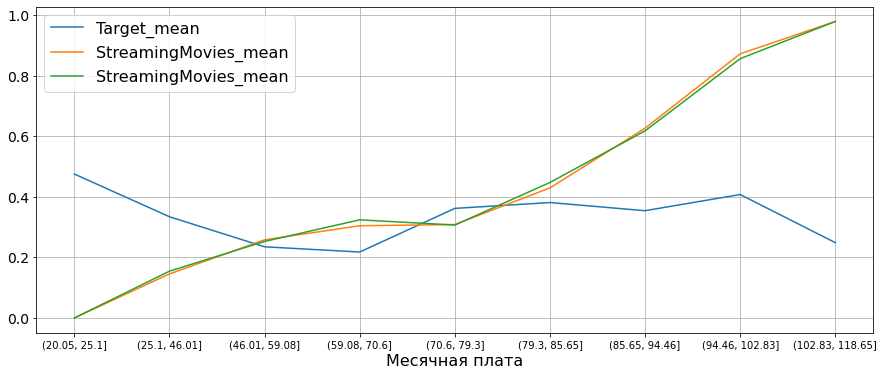

In [239]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
l1 = plt.plot(t.index.astype('string'), t['Target_mean'], label = 'Target_mean')
l2 = plt.plot(t.index.astype('string'), t['StreamingTV_mean'], label = 'StreamingMovies_mean')
l3 = plt.plot(t.index.astype('string'), t['StreamingMovies_mean'], label = 'StreamingMovies_mean')

plt.tick_params(axis='y', which='major', labelsize=14)
plt.xlabel('Месячная плата', fontsize = 16)
axs.legend()
plt.grid()
plt.legend(fontsize = 16)

InternetService, StreamingTV, StreamingMovies однозначно связаны с ценой. При увеличении цены растет веротность подключения этих услуг

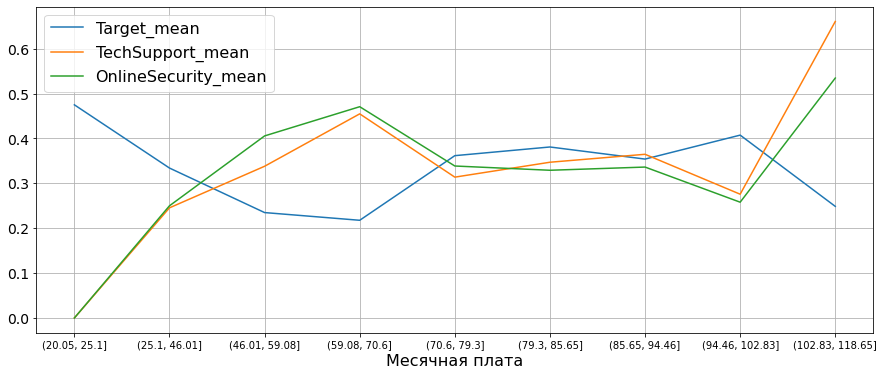

In [240]:
fig, axs = plt.subplots(1, 1, figsize=(15, 6))
l1 = plt.plot(t.index.astype('string'), t['Target_mean'], label = 'Target_mean')
l2 = plt.plot(t.index.astype('string'), t['TechSupport_mean'], label = 'TechSupport_mean')
l3 = plt.plot(t.index.astype('string'), t['OnlineSecurity_mean'], label = 'OnlineSecurity_mean')

plt.tick_params(axis='y', which='major', labelsize=14)
plt.xlabel('Месячная плата', fontsize = 16)
axs.legend()
plt.grid()
plt.legend(fontsize = 16)

Лучше всего с изменением целевого признака коррелирует наличие услуг OnlineSecurity	и TechSupport. Чем выше среднее значение OnlineSecurity	и TechSupport, тем меньше вероятность оттока

In [57]:
telecom.groupby('Type')['Target'].agg(['count','mean'])

,count,mean
Type,,
Month-to-month,3085,0.430794
One year,1182,0.106599
Two year,1358,0.029455


Type  сильно взаимосвязан с Target. При заключении двух летнего контракта клиенты практически не уходят

In [58]:
telecom.groupby('PaperlessBilling')['Target'].agg(['count','mean'])

,count,mean
PaperlessBilling,,
No,2276,0.164763
Yes,3349,0.334428


При безналичном расчете клиенты уходят чаще

In [59]:
telecom.groupby('PaymentMethod')['Target'].agg(['count','mean'])

,count,mean
PaymentMethod,,
Bank transfer (automatic),1235,0.160324
Credit card (automatic),1215,0.153909
Electronic check,1907,0.454116
Mailed check,1268,0.192429


Наибольший отток показывают клиенты с electronic check. Всех остальных можно объединить в одну категорию

In [60]:
telecom.groupby('MultipleLines', dropna=False)['Target'].agg(['count','mean'])

,count,mean
MultipleLines,,
No,2695,0.248237
Yes,2385,0.288470
no_phone,545,0.253211


Условия по MultipleLines не влияет на отток, в том числе для клиентов у которых нет телефонной линии

In [61]:
telecom.groupby('gender', dropna=False)['Target'].agg(['count','mean'])

,count,mean
gender,,
Female,2802,0.268380
Male,2823,0.263195


Пол пользователя не оказывает влияния на вероятность оттока

## Экспериментирование с комбинациями признаков

Добавляем столбец в котором будет стоять 1 если хотя бы одна из услуг OnlineSecurity или  TechSupport подключена

In [62]:
def sec_and_sup(row):
  result = row['OnlineSecurity'] + row['TechSupport'] 
  if result >=1:
    return 1
  else:
    return 0

telecom_internet_only['Security&Support'] = telecom_internet_only.apply(sec_and_sup, axis =1) 

In [63]:
telecom_internet_only.groupby('Target', dropna=False)[['OnlineSecurity','TechSupport', 'Security&Support']].agg(['count','mean'])

OnlineSecurity           TechSupport           Security&Support  \
                count      mean       count      mean            count   
Target                                                                   
0                3011  0.458984        3011  0.466290             3011   
1                1406  0.165007        1406  0.180654             1406   

                  
            mean  
Target            
0       0.659582  
1       0.289474

## Выбор признаков для обучения модели

In [64]:
num_features_selected = ['ClientLifetime_M', 'ClientLifetime_D', 'MonthlyCharges' , 'Dependents']

In [65]:
cat_features_selected = ['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService',
'OnlineSecurity', 'TechSupport']

In [66]:
features_selected = num_features_selected + cat_features_selected

In [67]:
X_train, X_test = X_train[features_selected], X_test[features_selected]

In [68]:
X_train

,ClientLifetime_M,ClientLifetime_D,MonthlyCharges,Dependents,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,TechSupport
1408,65.0,1979.0,94.55,1,Two year,No,Credit card (automatic),Fiber optic,Yes,Yes
6992,26.0,792.0,35.75,0,Month-to-month,No,Electronic check,DSL,No,Yes
3349,68.0,2071.0,90.20,0,Two year,No,Credit card (automatic),Fiber optic,No,Yes
4486,3.0,92.0,84.30,0,Month-to-month,No,Electronic check,Fiber optic,No,No
3535,49.0,1492.0,40.65,0,Month-to-month,No,Bank transfer (automatic),DSL,Yes,No
...,...,...,...,...,...,...,...,...,...,...
3445,65.0,1979.0,70.95,0,One year,Yes,Bank transfer (automatic),Fiber optic,No,No
5115,15.0,456.0,75.30,0,Month-to-month,Yes,Credit card (automatic),Fiber optic,No,No
4128,36.0,1095.0,92.90,1,Two year,Yes,Credit card (automatic),DSL,Yes,Yes
4242,10.1,306.0,65.90,1,One year,Yes,Mailed check,DSL,No,No


# Подготовка данных для алгортимов машинного обучения

## Cоздание новых признаков

In [69]:
class Add_features(BaseEstimator, TransformerMixin):
  def __init__(self, add_comb_sec_sup, el_check, lifetime_month):
    # Добавляем бинарный признак, который равен 1 если равно 1 значение хотя бы в одном из столбцов OnlineSecurity или TechSupport
    self.add_comb_sec_sup = add_comb_sec_sup
    # Переименовываем значения в столбце 'PaymentMethod', там где стоит "electronic check" проставляем electronic, во всех остальных случаях 'no_electronic'
    self.el_check = el_check
    # Оставляем или ClientLifetime_D или ClientLifetime_M
    self.lifetime_month = lifetime_month
  def fit(self, X, y= None):
    return self
  def transform(self, X, y= None):
    df=pd.DataFrame(X).copy()
    if self.add_comb_sec_sup: 
      def sec_sup(row):
        k = row['OnlineSecurity'] + row['TechSupport'] 
        if k>=1:
          return 1
        else:
          return 0
      df['Sec&Sup&Back&Prot'] = df.apply(sec_sup, axis=1)
      df = df.drop(['TechSupport','OnlineSecurity'], axis=1).copy()

    if self.el_check: 
      def el_check(x):
        if x =='Electronic check':
          return 'electronic'
        else:
          return 'no_electronic'
      df['PaymentMethod'] = df['PaymentMethod'].apply(el_check)
        
    if self.lifetime_month: 
      df = df.drop(['ClientLifetime_D'], axis=1).copy()
    else:
      df = df.drop(['ClientLifetime_M'], axis=1).copy()
    return df 

## Обработка признаков

In [70]:
# Выполняем для того, чтобы после кодировки не оставались одинаковое столбцы , там где мы заполняли пропуски no_internet
class Prepare_columns(BaseEstimator, TransformerMixin):
  def __init__(self, prepare_columns=True):
    self.prepare_columns = prepare_columns
  def fit(self, X, y= None):
    return self
  def transform(self, X, y= None):
    df=pd.DataFrame(X).copy()
    if self.prepare_columns:
      df['no_internet'] = (df[list(set(data_internet.columns.tolist()) & set(features_selected))[1]] == 'no_internet')*1
      df = df.replace(['Yes', 'No', 'no_internet'],[1, 0, 0])
      df = df.replace(['Fiber optic', 'DSL'],[1, 0])
    return df

In [71]:
cat_transformer = Pipeline([('onehot', OneHotEncoder(drop='first'))])
num_transformer = Pipeline([('scaler', StandardScaler())])

In [72]:
col_transform = ColumnTransformer([
        ('cat', cat_transformer, make_column_selector(dtype_include=object)),
        ('num', num_transformer, make_column_selector(dtype_include=np.number))])

In [73]:
preprocessor = Pipeline([('Prepare', Prepare_columns()),
                         ('Adder', Add_features(add_comb_sec_sup = True ,el_check = False, lifetime_month=True)),
                          ('Transform', col_transform)])

In [74]:
preprocessor.fit_transform(X_train)

array([[ 0.        ,  1.        ,  1.        , ...,  1.12490211,
        -0.52296156,  1.16215573],
       [ 0.        ,  0.        ,  0.        , ..., -0.88896624,
        -0.52296156,  1.16215573],
       [ 0.        ,  1.        ,  1.        , ...,  1.12490211,
        -0.52296156,  1.16215573],
       ...,
       [ 0.        ,  1.        ,  1.        , ..., -0.88896624,
        -0.52296156,  1.16215573],
       [ 1.        ,  0.        ,  0.        , ..., -0.88896624,
        -0.52296156, -0.86046988],
       [ 0.        ,  0.        ,  0.        , ...,  1.12490211,
        -0.52296156, -0.86046988]])

# Выбор, обучение и точная настройка моделей

## Логистическая регрессия

In [75]:
lr = Pipeline([('prep', preprocessor),
            ('clf', LogisticRegression())])

In [76]:
param_grid_lr = {
    "prep__Adder__add_comb_sec_sup": [True, False],
    "prep__Adder__el_check": [True, False],
    "prep__Adder__lifetime_month": [True, False],
    "clf__C": [0.1, 1.0, 10]}

In [77]:
kfolds = StratifiedKFold(5, shuffle=True, random_state =10)

In [78]:
grid_search_lr = GridSearchCV(lr, param_grid_lr,scoring='roc_auc', cv=kfolds.split(X_train, y_train))

In [79]:
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fd173222270>,
             estimator=Pipeline(steps=[('prep',
                                        Pipeline(steps=[('Prepare',
                                                         Prepare_columns()),
                                                        ('Adder',
                                                         Add_features(add_comb_sec_sup=True,
                                                                      el_check=False,
                                                                      lifetime_month=True)),
                                                        ('Transform',
                                                         ColumnTransformer(transformers=[('cat',
                                                                                          Pipeline(steps=[('onehot',
                                                                                                           OneHotEncoder(drop='first'))]),
                                                                                          <sklearn.compo...
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1733ec3d0>)]))])),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.1, 1.0, 10],
                         'prep__Adder__add_comb_sec_sup': [True, False],
                         'prep__Adder__el_check': [True, False],
                         'prep__Adder__lifetime_month': [True, False]},
             scoring='roc_auc')

In [80]:
round(grid_search_lr.best_score_,3)

0.843

In [81]:
final_model_lr = grid_search_lr.best_estimator_

In [82]:
cv_results_lr = pd.DataFrame(grid_search_lr.cv_results_)

In [83]:
cv_results_lr[["mean_test_score", 'param_clf__C', 'param_prep__Adder__add_comb_sec_sup', 'param_prep__Adder__el_check', 'param_prep__Adder__lifetime_month']].sort_values(by='mean_test_score', ascending = False).head(10)


,mean_test_score,param_clf__C,param_prep__Adder__add_comb_sec_sup,param_prep__Adder__el_check,param_prep__Adder__lifetime_month
9,0.843098,1.0,True,True,False
17,0.843084,10,True,True,False
16,0.843062,10,True,True,True
8,0.843049,1.0,True,True,True
1,0.842782,0.1,True,True,False
0,0.842758,0.1,True,True,True
11,0.842682,1.0,True,False,False
19,0.842668,10,True,False,False
10,0.842659,1.0,True,False,True
18,0.842631,10,True,False,True


In [186]:
feature_importance_lr = pd.DataFrame(grid_search_lr.best_estimator_.named_steps["clf"].coef_[0],
                                     index =  grid_search_lr.best_estimator_.named_steps["prep"]['Transform'].get_feature_names_out(),
                                     columns = ['Importance']).reset_index()


In [197]:
feature_importance_lr['Type_of_model'] = 'LR'
feature_importance_lr['Importance_norm'] = abs(feature_importance_lr['Importance'])/abs(feature_importance_lr['Importance']).max()
feature_importance_lr

,index,Importance,Type_of_model,Importance_norm
0,cat__Type_One year,-0.749662,LR,0.535981
1,cat__Type_Two year,-1.398672,LR,1.000000
2,cat__PaymentMethod_no_electronic,-0.415058,LR,0.296752
3,num__ClientLifetime_D,-0.726675,LR,0.519547
4,num__MonthlyCharges,0.343716,LR,0.245745
5,num__Dependents,-0.136867,LR,0.097855
6,num__PaperlessBilling,0.164234,LR,0.117422
7,num__InternetService,0.258605,LR,0.184893
8,num__no_internet,-0.330852,LR,0.236547
9,num__Sec&Sup&Back&Prot,-0.314172,LR,0.224622


## Случайный лес

In [86]:
rf = Pipeline([('prep', preprocessor),
            ('clf', RandomForestClassifier())])

In [87]:
param_grid_rf = {
    "prep__Adder__add_comb_sec_sup": [True, False],
    "prep__Adder__el_check": [True, False],
    "prep__Adder__lifetime_month": [True, False],
    'clf__max_depth': [3, 5, 7, 10],
    'clf__n_estimators': [50, 100, 150]
}

In [88]:
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='roc_auc', cv=kfolds.split(X_train, y_train))

In [89]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fd1733043c0>,
             estimator=Pipeline(steps=[('prep',
                                        Pipeline(steps=[('Prepare',
                                                         Prepare_columns()),
                                                        ('Adder',
                                                         Add_features(add_comb_sec_sup=True,
                                                                      el_check=False,
                                                                      lifetime_month=True)),
                                                        ('Transform',
                                                         ColumnTransformer(transformers=[('cat',
                                                                                          Pipeline(steps=[('onehot',
                                                                                                           OneHotEncoder(drop='first'))]),
                                                                                          <sklearn.compo...
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fd1733ec3d0>)]))])),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__max_depth': [3, 5, 7, 10],
                         'clf__n_estimators': [50, 100, 150],
                         'prep__Adder__add_comb_sec_sup': [True, False],
                         'prep__Adder__el_check': [True, False],
                         'prep__Adder__lifetime_month': [True, False]},
             scoring='roc_auc')

In [90]:
round(grid_search_rf.best_score_,3)

0.864

In [91]:
final_model_rf = grid_search_rf.best_estimator_

In [92]:
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)

In [93]:
cv_results_rf[["mean_test_score", 'param_clf__max_depth', 'param_clf__n_estimators', 'param_prep__Adder__add_comb_sec_sup', 'param_prep__Adder__el_check', 'param_prep__Adder__lifetime_month']].sort_values(by='mean_test_score', ascending = False).head(10)


,mean_test_score,param_clf__max_depth,param_clf__n_estimators,param_prep__Adder__add_comb_sec_sup,param_prep__Adder__el_check,param_prep__Adder__lifetime_month
49,0.863721,7,50,True,True,False
65,0.863041,7,150,True,True,False
57,0.862246,7,100,True,True,False
81,0.861971,10,100,True,True,False
53,0.861807,7,50,False,True,False
89,0.861656,10,150,True,True,False
51,0.861439,7,50,True,False,False
69,0.861181,7,150,False,True,False
85,0.861117,10,100,False,True,False
67,0.861038,7,150,True,False,False


In [192]:
feature_importance_rf = pd.DataFrame(grid_search_rf.best_estimator_.named_steps["clf"].feature_importances_,
                                     index =  grid_search_rf.best_estimator_.named_steps["prep"]['Transform'].get_feature_names_out(),
                                     columns = ['Importance']).reset_index()


In [198]:
feature_importance_rf['Type_of_model'] = 'RF'
feature_importance_rf['Importance_norm'] = feature_importance_rf['Importance']/(feature_importance_rf['Importance'].max())
feature_importance_rf

,index,Importance,Type_of_model,Importance_norm
0,cat__Type_One year,0.036719,RF,0.087843
1,cat__Type_Two year,0.069804,RF,0.166988
2,cat__PaymentMethod_no_electronic,0.081191,RF,0.194230
3,num__ClientLifetime_D,0.418015,RF,1.000000
4,num__MonthlyCharges,0.122246,RF,0.292443
5,num__Dependents,0.010609,RF,0.025380
6,num__PaperlessBilling,0.019617,RF,0.046928
7,num__InternetService,0.126956,RF,0.303712
8,num__no_internet,0.052005,RF,0.124410
9,num__Sec&Sup&Back&Prot,0.062838,RF,0.150324


## Catboost

Разделим предобработку и обучение модели. Исходя из опыта обучения логистической регрессии и случайного леса, выберем оптимальные параметры предобработки

In [155]:
preprocessor = Pipeline([('Prepare', Prepare_columns()),
                         ('Adder', Add_features(add_comb_sec_sup = True ,el_check = True, lifetime_month=False)),
                          ('Transform', col_transform)])

In [156]:
X_train_prepare = preprocessor.fit_transform(X_train)
X

array([[ 0.        ,  1.        ,  1.        , ...,  1.12490211,
        -0.52296156,  1.16215573],
       [ 0.        ,  0.        ,  0.        , ..., -0.88896624,
        -0.52296156,  1.16215573],
       [ 0.        ,  1.        ,  1.        , ...,  1.12490211,
        -0.52296156,  1.16215573],
       ...,
       [ 0.        ,  1.        ,  1.        , ..., -0.88896624,
        -0.52296156,  1.16215573],
       [ 1.        ,  0.        ,  1.        , ..., -0.88896624,
        -0.52296156, -0.86046988],
       [ 0.        ,  0.        ,  0.        , ...,  1.12490211,
        -0.52296156, -0.86046988]])

In [157]:
model_cb =  CatBoostClassifier(eval_metric='AUC')

In [99]:
grid_cb = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}

In [100]:
grid_search_cb = GridSearchCV(model_cb, grid_cb, scoring='roc_auc', cv=kfolds.split(X_train_prepare, y_train))

In [101]:
grid_search_cb.fit(X_train_prepare, y_train)

0:	total: 47.3ms	remaining: 47.3s
1:	total: 48.8ms	remaining: 24.4s
2:	total: 50.6ms	remaining: 16.8s
3:	total: 51.8ms	remaining: 12.9s
4:	total: 52.8ms	remaining: 10.5s
5:	total: 53.8ms	remaining: 8.91s
6:	total: 54.9ms	remaining: 7.79s
7:	total: 56ms	remaining: 6.95s
8:	total: 57.4ms	remaining: 6.32s
9:	total: 58.4ms	remaining: 5.79s
10:	total: 59.6ms	remaining: 5.36s
11:	total: 60.8ms	remaining: 5s
12:	total: 61.9ms	remaining: 4.7s
13:	total: 63.1ms	remaining: 4.44s
14:	total: 64.2ms	remaining: 4.22s
15:	total: 65.4ms	remaining: 4.02s
16:	total: 66.6ms	remaining: 3.85s
17:	total: 67.7ms	remaining: 3.69s
18:	total: 68.9ms	remaining: 3.56s
19:	total: 70.1ms	remaining: 3.43s
20:	total: 71.4ms	remaining: 3.33s
21:	total: 72.6ms	remaining: 3.23s
22:	total: 74ms	remaining: 3.14s
23:	total: 75ms	remaining: 3.05s
24:	total: 76.4ms	remaining: 2.98s
25:	total: 77.4ms	remaining: 2.9s
26:	total: 78.6ms	remaining: 2.83s
27:	total: 79.7ms	remaining: 2.77s
28:	total: 80.8ms	remaining: 2.71s
29:	to

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fd173304ac0>,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd173270e20>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring='roc_auc')

In [102]:
round(grid_search_cb.best_score_,3)

0.933

In [103]:
final_model_cb = grid_search_cb.best_estimator_

In [119]:
cv_results_cb = pd.DataFrame(grid_search_cb.cv_results_)

In [120]:
cv_results_cb[["mean_test_score", 'param_depth', 'param_learning_rate', ]].sort_values(by='mean_test_score', ascending = False).head(10)


,mean_test_score,param_depth,param_learning_rate
1,0.933131,4,0.1
3,0.925749,6,0.1
2,0.921197,6,0.03
0,0.917648,4,0.03
4,0.906648,10,0.03
5,0.903321,10,0.1


In [200]:
feature_importance_cb = pd.DataFrame(grid_search_cb.best_estimator_.feature_importances_, 
                                     index =  col_transform.get_feature_names_out(), 
                                     columns = ['Importance']).reset_index()


In [201]:
feature_importance_cb['Type_of_model'] = 'CB'
feature_importance_cb['Importance_norm'] = feature_importance_cb['Importance']/(feature_importance_cb['Importance'].max())
feature_importance_cb

,index,Importance,Type_of_model,Importance_norm
0,cat__Type_One year,1.777271,CB,0.025415
1,cat__Type_Two year,4.181041,CB,0.059790
2,cat__PaymentMethod_no_electronic,1.376263,CB,0.019681
3,num__ClientLifetime_D,69.929352,CB,1.000000
4,num__MonthlyCharges,13.711640,CB,0.196078
5,num__Dependents,1.303071,CB,0.018634
6,num__PaperlessBilling,1.238185,CB,0.017706
7,num__InternetService,3.347234,CB,0.047866
8,num__no_internet,1.427317,CB,0.020411
9,num__Sec&Sup&Back&Prot,1.708627,CB,0.024434


## Feature importance

In [202]:
feature_importance = feature_importance_lr.append(feature_importance_rf).append(feature_importance_cb)

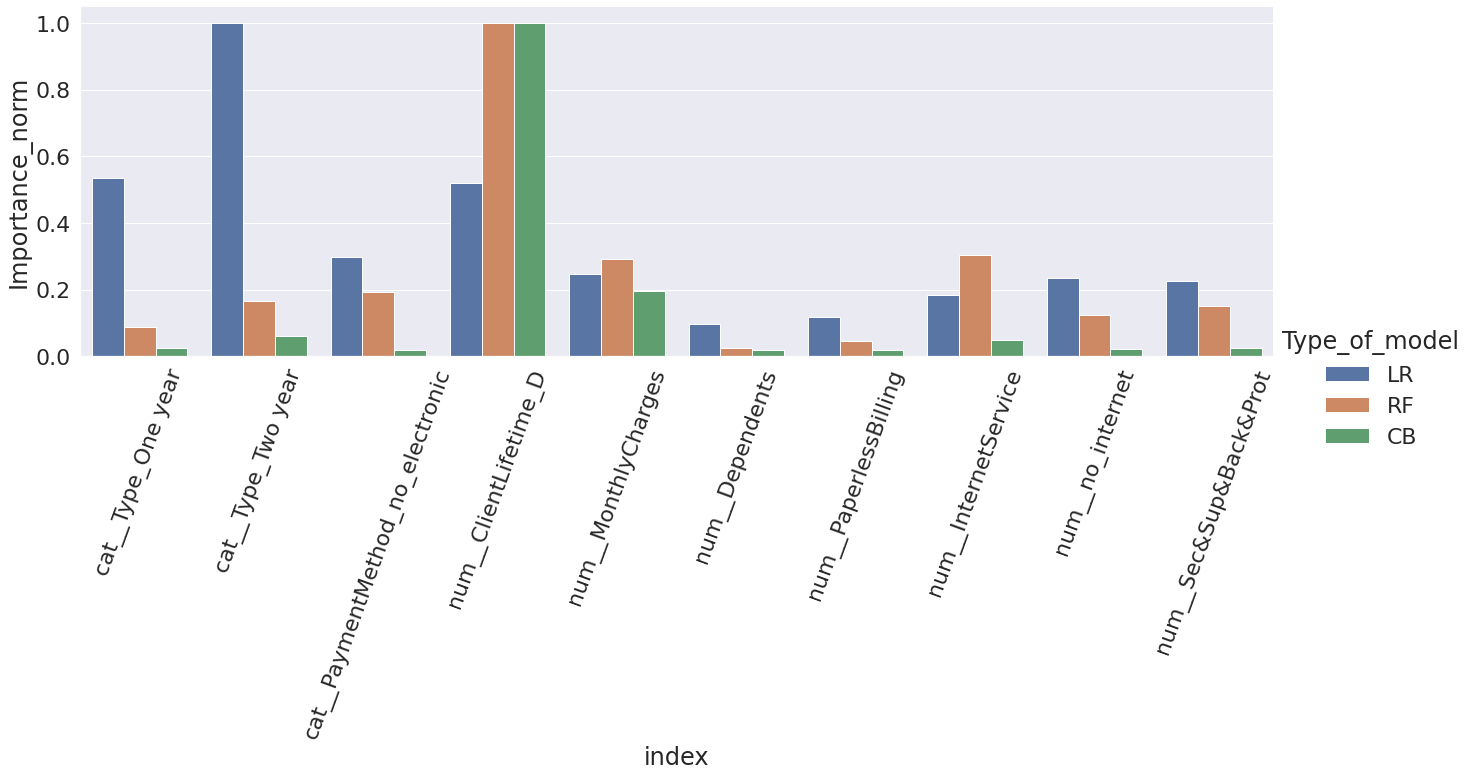

In [248]:
sns.catplot(x="index", y="Importance_norm", hue="Type_of_model", kind="bar", 
            height=6, aspect=3, data=feature_importance)
degrees = 70
plt.xticks(rotation = degrees)
sns.set(font_scale = 2)

1. Похоже, что признаки Dependents и PaperlessBilling оказываются малозначимыми для всех рассмотренных моделей
2. LR "более равномерно" использует признаки для предсказаний, в то время как Сatboost опирается только на несколько

# Проверка моделей на тестовой выборке

In [108]:
print('Логистическая регрессия')
final_predictions_lr = final_model_lr.predict_proba(X_test)[:,1]
round(roc_auc_score(y_test, final_predictions_lr),3)

Логистическая регрессия


0.833

In [109]:
print('Случайный лес')
final_predictions_rf = final_model_rf.predict_proba(X_test)[:,1]
round(roc_auc_score(y_test, final_predictions_rf),3)

Случайный лес


0.856

In [110]:
X_test_prepare = preprocessor.transform(X_test)

In [111]:
print('Catboost')
final_predictions_cb = final_model_cb.predict_proba(X_test_prepare)[:,1]
round(roc_auc_score(y_test, final_predictions_cb),3)

Catboost


0.932

In [225]:
results = pd.DataFrame({'Model': ['LR', 'RF', 'CB'], 
                        'Train Results (ROC AUC)': [round(grid_search_lr.best_score_,3), round(grid_search_rf.best_score_,3), round(grid_search_cb.best_score_,3)],
                       'TEST Results (ROC AUC)': [round(roc_auc_score(y_test, final_predictions_lr),3), round(roc_auc_score(y_test, final_predictions_rf),3), round(roc_auc_score(y_test, final_predictions_cb),3)]
                       })
results

,Model,Train Results (ROC AUC),TEST Results (ROC AUC)
0,LR,0.843,0.833
1,RF,0.864,0.856
2,CB,0.933,0.932


# Отчет

1. Какие пункты плана были выполнены, а какие — нет (поясните почему)?

В целом были выполнены все пункты плана. Единственное, в п. 2.3 (Выбор признаков для обучения модели) я планировал попробовать использовать какой-нибудь автоматический алгортим выбора признаков и сравнить результат обучения на таких признаках, с результатом, полученным после отбора на основе исследовательского анализа. Но в итоге не успел из-за трудностей с достижением нужного уровня метрики.

2. Какие трудности возникли и как вы их преодолели?

a) Довольно долго не удавалось достичь значения метрики >=0.85 на тестовой выборке. На этом этапе я использовал модели логистической регресии и случайного леса. Пытался придумать какие-то новые признаки, по- разному комбинируя данные из столбцов 'OnlineSecurity', 'TechSupport', 'OnlineBackup', 'DeviceProtection'. 

В итоге после подсказки ревьювера я перевел "длительность жизни клиента" (столбец ClientLifetime) из месяцев в дни, точнее даже я сделал два столбца - и в днях и в месяцях, а потом уже  в  pipeline запараметризовал выбор конкретного их этих двух вариантов и перебором в grid search выбрал лучший. Это позволило уже для модели случайного леса повысить метрику до требуемеого уровня. Для себя такой результат я объяснил следующим образом:
1. несмотря на то, что в столбцах begin_date  и end_date стоит всегда первое число месяца, при переводе разницы этих дат в месяцы не всегда получается целое число, что странно
2. скорее всего это связано с тем, что штатным способ перевода не корректно учитывается был ли год високосным

Кроме того, по совету ревьювера попробовал модель catboost. В данной задаче это позволило очень заметно улучшить значение метрики

b) Были проблемы с выбором столбцов/удалением столбцов после применения column transformator

Cтолбцы InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies после формирования датафрейма содержали пропуски в одних и тех же строках, которые мы заполняли одинаково ('no_internet'). Это, В свою очередь, при кодировке во время предобработки приводило к появлению одинаковых столбцов, от которых нужно было избавляться. В итоге я не смог разобраться как это сделать средствами sklearn  и решил данную проблему за счет дополнительного кастомного предобработчика Prepare_columns. Он переводил ячейки указанных столбцах в числовые и заполнял строки "Уes"  единицами, а "no-internet" и  "No" нулями, создавая при этом один отдельный столбец с 1 напротив "No_internet"

3. Какие ключевые шаги в решении задачи выделили?

a) Предобработка данных. 
 
Включает в себя формирование единого датафрейма, выделение целевого признака, разбиение имеющихся данных на выборки train и test
 
 
b) Анализ данных. 

Включает в себя поиск взаимосвязей между признаками и между каждым признаком и целевым признаком, попытки создания новых признаков (более связанных с целевым), отбор признаков для обучения моделей

c) Выбор моделей и тюнинг их гиперпараметров. Определение наиболее влияющих на предсказания моделей признаков

d) Проверка моделей с оптимальными гиперпараметрами на тестовой выборке

4. Какая ваша итоговая модель и какое у неё качество?

В итоге наилучшие результаты показал catboost со значением целевой метрики roc auc на тестовой выборке 0.93